In [81]:
!pip install torch

In [82]:
!pip install nibabel
!pip install matplotlib

In [83]:
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [84]:
model = torch.load('GRACE.pth', map_location=torch.device('cpu'))

/tmp/ipykernel_9470/498950991.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('GRACE.pth', map_location=torch.device('cpu'))


In [85]:
model.keys()

odict_keys(['module.vit.patch_embedding.position_embeddings', 'module.vit.patch_embedding.patch_embeddings.1.weight', 'module.vit.patch_embedding.patch_embeddings.1.bias', 'module.vit.blocks.0.mlp.linear1.weight', 'module.vit.blocks.0.mlp.linear1.bias', 'module.vit.blocks.0.mlp.linear2.weight', 'module.vit.blocks.0.mlp.linear2.bias', 'module.vit.blocks.0.norm1.weight', 'module.vit.blocks.0.norm1.bias', 'module.vit.blocks.0.attn.out_proj.weight', 'module.vit.blocks.0.attn.out_proj.bias', 'module.vit.blocks.0.attn.qkv.weight', 'module.vit.blocks.0.norm2.weight', 'module.vit.blocks.0.norm2.bias', 'module.vit.blocks.1.mlp.linear1.weight', 'module.vit.blocks.1.mlp.linear1.bias', 'module.vit.blocks.1.mlp.linear2.weight', 'module.vit.blocks.1.mlp.linear2.bias', 'module.vit.blocks.1.norm1.weight', 'module.vit.blocks.1.norm1.bias', 'module.vit.blocks.1.attn.out_proj.weight', 'module.vit.blocks.1.attn.out_proj.bias', 'module.vit.blocks.1.attn.qkv.weight', 'module.vit.blocks.1.norm2.weight', 'mod

In [86]:
# input_data = nib.load('../Task1/brain/1BA001/mr.nii.gz')
input_data = nib.load('../Task1/brain/1BA005/mr.nii.gz')

In [87]:
input_data.get_fdata().shape

(232, 271, 206)

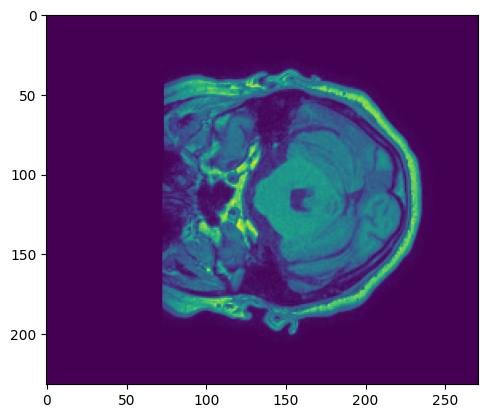

In [88]:
img = input_data.get_fdata()
slice_number = 80
plt.imshow(img[:,:,slice_number])
plt.show()

In [89]:
model(input_data)

TypeError: 'collections.OrderedDict' object is not callable

I dont have access to the model architecture. I also couldn't find it in their github 
no wait. I may have found it :)))

In [52]:
!pip install monai
!pip install tqdm
!pip install scipy
!pip install einops

     |████████████████████████████████| 43 kB 731 kB/s eta 0:00:01


In [25]:
from monai.networks.nets import UNETR

First lets see how they manage to run the model. Then I try to replicate using my data

In [2]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import time
import argparse
from scipy.io import savemat
import einops

#load monai functions - 

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    # AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    SpatialPadd,
    RandGaussianNoised,
    ToDeviced,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, BasicUNet
#from monai.networks.nets import UNet

from monai.data import (
    DataLoader,
    load_decathlon_datalist,
    decollate_batch,
    Dataset,
    pad_list_data_collate,
)

In [ ]:
# dataset_dir = [os.path.join('../Task1/brain/', mri_path, 'mr.nii.gz') for mri_path in os.listdir('../Task1/brain/')]
# dataset = [{'image':dir, 'label':i} for i,dir in enumerate(dataset_dir)]
# load_decathlon_datalist(dict(dataset))
# load_decathlon_datalist(dict(dataset))

In [44]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        # AddChanneld(keys=["image"]),
        Spacingd(
            keys=["image"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image"]),
        #ToDeviced(keys=["image", "label"], device=device),
    ]
    )

# test_files = load_decathlon_datalist(datasets, True, "test")
dataset_dir = [os.path.join('../Task1/brain/', mri_path, 'mr.nii.gz') for mri_path in os.listdir('../Task1/brain/')]
dataset_dir = dataset_dir[:3] # only check for three MRIs
test_files = [{'image':dir, 'label':i} for i,dir in enumerate(dataset_dir)]
# test_files = [{'image':dir, 'label':i, 'dir':dir} for i,dir in enumerate(dataset_dir)]

test_ds = Dataset(
    data=test_files, transform=test_transforms, 
)
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, collate_fn=pad_list_data_collate,
)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR(
    in_channels=1,
    out_channels=12, #12 for all tissues
    img_size=(64,64,64),
    feature_size=16, 
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [20]:
from collections import OrderedDict

In [57]:
grace_load = torch.load('GRACE.pth', map_location=torch.device('cpu'), weights_only=False)
grace_load = OrderedDict([(k[7:],v) for k,v in grace_load.items()])

model.load_state_dict(grace_load)
model.eval()
spatial_size = 64

with torch.no_grad():
    img = test_ds[0]['image']
    # test_inputs = torch.unsqueeze(img, 1).to(device)
    test_inputs = img.unsqueeze(0).unsqueeze(1).to(device)
    test_outputs = sliding_window_inference(test_inputs, (spatial_size, spatial_size, spatial_size), 1, model, overlap=0.8)

# case_num = len(test_ds)
# for i in range(case_num):
#     #start_time = time.time()
#     with torch.no_grad():
#         img_name = os.path.split(test_ds[i]["img_name"]["filename_or_obj"])[1]
#         img = test_ds[i]["image"]
#         test_inputs = torch.unsqueeze(img, 1).cuda()
#         #start_time = time.time()
#         test_outputs = sliding_window_inference(test_inputs, (args.spatial_size, args.spatial_size, args.spatial_size), 4, model, overlap=0.8)
#         #print("--- %s seconds ---" % (time.time() - start_time))
#     #logits = test_outputs.detach().cpu().numpy()
#     testimage = torch.argmax(test_outputs, dim=1).detach().cpu().numpy()
#     #savepath = 'testimage' + str(i) + '.mat'
#     filename, file_extension = os.path.splitext(img_name)
#     savepath = filename + '.mat'
#     savemat(os.path.join(args.data_dir,savepath), {'testimage':testimage})#, 'logits':logits})
#     #print("--- %s seconds ---" % (time.time() - start_time))


In [63]:
savemat('grace_one_img.mat',{'image':test_outputs.detach().cpu().numpy()})

In [55]:
# test_inputs.shapetestimage = torch.argmax(test_outputs, dim=1).detach().cpu().numpy()
img.unsqueeze(0).shape

torch.Size([1, 212, 246, 181])

In [43]:
img = nib.load(test_ds[0]['dir']).get_fdata()
img.shape
# plt.imshow(img[:,:,slice_number])
# plt.show()

/home/taha/Downloads/Panacea/Code/venv/lib/python3.8/site-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (246, 181), channels = 212,please make sure the input is in the channel-first format.
  warnings.warn(


(212, 246, 181)

In [16]:
d = torch.load('GRACE.pth', map_location=torch.device('cpu'))
d = [(k[7:],v) for k,v in d.items()]
d

/tmp/ipykernel_9470/948810063.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load('GRACE.pth', map_location=torch.device('cpu'))


[('vit.patch_embedding.position_embeddings',
  tensor([[[-0.0030, -0.0345, -0.0031,  ...,  0.0329, -0.0101,  0.0131],
           [ 0.0131, -0.0413, -0.0405,  ..., -0.0277, -0.0285,  0.0124],
           [ 0.0535, -0.0034, -0.0058,  ...,  0.0361, -0.0196, -0.0100],
           ...,
           [-0.0185, -0.0056,  0.0527,  ..., -0.0452,  0.0074,  0.0030],
           [ 0.0058,  0.0472,  0.0362,  ..., -0.0255,  0.0019, -0.0259],
           [ 0.0092, -0.0114,  0.0010,  ..., -0.0008, -0.0013, -0.0012]]])),
 ('vit.patch_embedding.patch_embeddings.1.weight',
  tensor([[ 0.0108,  0.0117,  0.0197,  ...,  0.0316,  0.0243,  0.0503],
          [ 0.0167,  0.0167,  0.0133,  ...,  0.0002,  0.0425,  0.0557],
          [ 0.0156, -0.0114,  0.0351,  ..., -0.0067, -0.0338,  0.0109],
          ...,
          [-0.0307, -0.0088, -0.0168,  ..., -0.0069, -0.0144, -0.0624],
          [ 0.0040,  0.0017, -0.0056,  ..., -0.0125, -0.0256, -0.0673],
          [ 0.0270,  0.0110,  0.0016,  ..., -0.0322, -0.0453, -0.0686]]

In [64]:
testimage = torch.argmax(test_outputs, dim=1).detach().cpu().numpy()

In [66]:
testimage.shape

(1, 212, 246, 181)

In [68]:
testimage.squeeze(0).shape

(212, 246, 181)

In [77]:
a = testimage.squeeze(0)
unique, counts = np.unique(a, return_counts=True)
print(np.asarray((unique, counts)).T)

[[      0 6203365]
 [      1  465623]
 [      2  630326]
 [      3     848]
 [      4  360131]
 [      5   34501]
 [      6     993]
 [      7   72067]
 [      8  456159]
 [      9  275962]
 [     10  275844]
 [     11  663693]]


In [90]:
LIGHT_BLUE = '#00ffff'
ORANGE = '#ff8040'
PURPLE = '#8000ff'
GREEN = '#16a70b'
LIGHT_PINK = '#ff80c0'
DARK_GREEN = '#008100'
DARK_BLUE = '#0000ff'
NEON_PINK = '#ff00ff'
LIGHT_GREEN = '#00ff00'
GRAY = '#909091' #FIXME: match with image in Drive
TAN = '#ebda96'
LIGHT_RED = '#fa8072'
BLACK = '#000000ff'
BLACK_TRANSPARENT = '#00000000'

#               Light blue          orange              Purple                 Green                   light pink       dark green      dark blue         neon pink            light green      grey                    tan                 light red
RGB_VALUES = [(0, 255, 255, 255), (255, 128, 64, 255), (128, 0, 255, 255), (22, 167, 11, 255), (255, 128, 192, 255), (0, 129, 0, 255), (0, 0, 255, 255), (255, 0, 255, 255), (0, 255, 0, 255), (144, 144, 145, 255), (235, 218, 150, 255), (250, 128, 114, 255)]
RANGES = [[0, 0.5], [0.5, 1.5], [1.5, 2.5], [2.5, 3.5], [3.5, 4.5], [4.5, 5.5], [5.5, 6.5], [6.5, 7.5], [7.5, 8.5], [8.5, 9.5], [9.5, 10.5], [10.5, 11.5]]

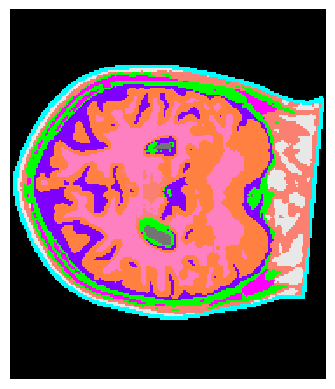

In [91]:
from matplotlib.colors import ListedColormap

slice_number = 80
image = testimage.squeeze(0)[:,slice_number,:]
plt.imshow(image, cmap='gray', interpolation='none')
plt.axis('off')


rgba_colors = [BLACK_TRANSPARENT, LIGHT_PINK, ORANGE, GRAY, PURPLE, BLACK_TRANSPARENT, DARK_BLUE, NEON_PINK, LIGHT_GREEN, LIGHT_BLUE, BLACK_TRANSPARENT, LIGHT_RED]
outline_list = [(250, 128, 114, 255), (0, 255, 255, 255), (0, 255, 0, 255), (255, 0, 255, 255), (0, 0, 255, 255), (128, 0, 255, 255), (144, 144, 145, 255), (255, 128, 64, 255), (255, 128, 192, 255)]
outline_list = outline_list[::-1]
for num, color in enumerate(rgba_colors):
    if color == BLACK_TRANSPARENT:
        continue
    cmap = ListedColormap([color])
    cmap.set_over((0, 0, 0, 0))
    cmap.set_under((0, 0, 0, 0))
    cmap.set_bad((0, 0, 0, 0))
    plt.imshow(image, cmap=cmap, interpolation='none', vmin=RANGES[num][0], vmax=RANGES[num][1])


plt.show()

In [19]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch
import nibabel as nib

In [4]:
mat = loadmat('grace_one_img.mat')['image']

In [6]:
mat.shape

(1, 12, 212, 246, 181)

In [17]:
image = torch.argmax(torch.asarray(mat), dim=1).numpy().squeeze(0)
image.shape

(212, 246, 181)

In [25]:
image_nii = nib.Nifti1Image(image, affine=np.eye(4), dtype=np.int64)
nib.save(image_nii, 'grace_one_img.nii')

In [26]:
image.shape[2]

181

In [63]:
volume_per_slice = np.zeros(image.shape[2])
tissue_labels = [9, 10, 11] # skin, fat, muscle

for z in range(image.shape[2]):
    volume_per_slice[z] = np.sum(np.isin(image[:, :, z], tissue_labels))

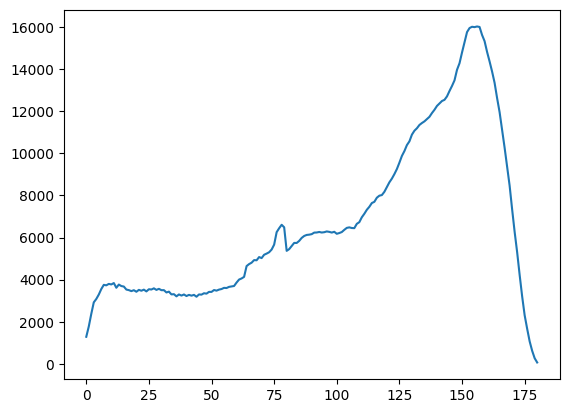

In [30]:
plt.plot(volume_per_slice)

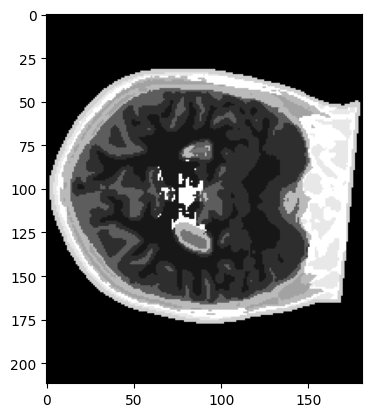

In [39]:
slice_number = 80
plt.imshow(image[:,slice_number,:], cmap='gray')
plt.show()

In [68]:
vals = list(enumerate(volume_per_slice))
sorted_by_second = sorted(vals, key=lambda tup: -tup[1])
sorted_by_second[:5]

[(156, 16014.0),
 (154, 16000.0),
 (157, 15991.0),
 (155, 15983.0),
 (153, 15939.0)]

Smoothout the result

[(155, 15985.400000000001),
 (154, 15936.800000000003),
 (156, 15919.800000000003),
 (153, 15787.000000000002),
 (157, 15783.600000000002)]

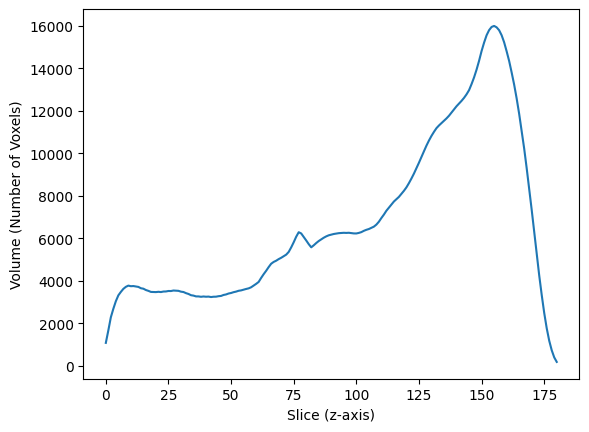

In [78]:
window_size = 5
volume_per_slice_smoothed = np.convolve(volume_per_slice, np.ones(window_size)/window_size, mode='same')
_ = plt.plot(volume_per_slice_smoothed)
plt.xlabel('Slice (z-axis)')
plt.ylabel('Volume (Number of Voxels)')
vals = list(enumerate(volume_per_slice_smoothed))
sorted_by_second = sorted(vals, key=lambda tup: -tup[1])
sorted_by_second[:5]

In [77]:
diff = np.diff(volume_per_slice_smoothed)
vals = list(enumerate(diff))
sorted_by_second = sorted(vals, key=lambda tup: -tup[1])
sorted_by_second[:7]

[(1, 616.5999999999999),
 (0, 584.8000000000002),
 (149, 458.0),
 (148, 414.60000000000036),
 (2, 400.7999999999997),
 (150, 396.2000000000007),
 (147, 365.60000000000036)]

find first cortical bone

Text(0.5, 0, 'cortical bone histogram in z direction')

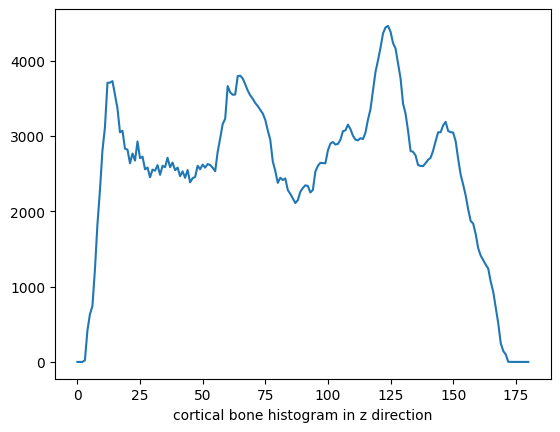

In [90]:
cortical_bone_label = 8
threshold = 500

cortical_bone_list = []
for z in range(image.shape[2]):
    cortical_bone_list.append(np.sum(image[:, :, z] == cortical_bone_label))
plt.plot(cortical_bone_list)
plt.xlabel('cortical bone histogram in z direction')

(array([2.8893e+04, 5.5810e+03, 5.7830e+03, 0.0000e+00, 2.4280e+03,
        3.3400e+02, 5.0000e+00, 1.4400e+02, 2.8070e+03, 1.3540e+03,
        4.8230e+03]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 11 artists>)

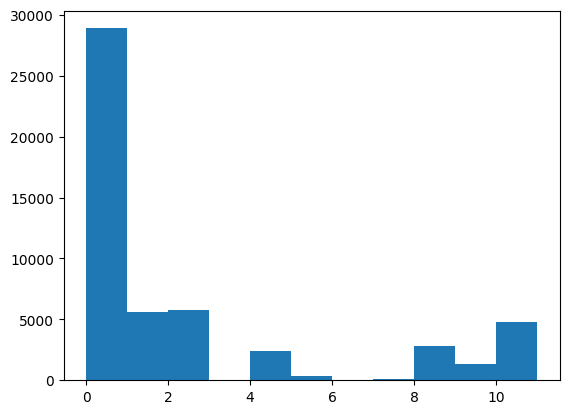

In [87]:
# how many pixels of each label do we have in a given slice
plt.hist(image[:,:,100].flatten(), bins=11)

In [100]:
neck_threshold = 149

neck_mask = np.zeros_like(image, dtype=int)
neck_mask[image != 0] = 1
neck_mask[:,:,149:] = 0
neck_mask.shape

(212, 246, 181)

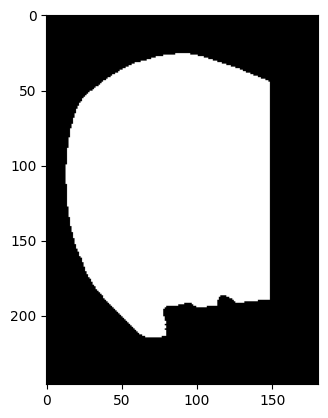

In [108]:
plt.imshow(neck_mask[140,:,:], cmap='gray')

In [106]:
neck_mask_nifti = nib.Nifti1Image(neck_mask, affine=np.eye(4), dtype=np.int16)
nib.save(neck_mask_nifti, '1BB033_neckMasked.nii')

## Grace application to MRIs script

In [ ]:
!pip install torch
!pip install SimpleITK
!pip install matplotlib
!pip install monai
!pip install tqdm
!pip install scipy
!pip install einops

In [1]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import time
import argparse
from scipy.io import savemat
import einops
from collections import OrderedDict

#load monai functions - 

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    # AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    SpatialPadd,
    RandGaussianNoised,
    ToDeviced,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, BasicUNet
#from monai.networks.nets import UNet

from monai.data import (
    DataLoader,
    load_decathlon_datalist,
    decollate_batch,
    Dataset,
    pad_list_data_collate,
)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        Spacingd(
            keys=["image"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
        ToTensord(keys=["image"]),
        # ToDeviced(keys=["image", "label"], device=device),
    ]
    )

# test_files = load_decathlon_datalist(datasets, True, "test")
dataset_dir = [os.path.join('../Task1/brain/', mri_path, 'mr.nii.gz') for mri_path in os.listdir('../Task1/brain/')]
dataset_dir = dataset_dir[:3] # only check for three MRIs
test_files = [{'image':dir, 'label':i} for i,dir in enumerate(dataset_dir)]
# test_files = [{'image':dir, 'label':i, 'dir':dir} for i,dir in enumerate(dataset_dir)]

test_ds = Dataset(
    data=test_files, transform=test_transforms, 
)
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, collate_fn=pad_list_data_collate,
)


model = UNETR(
    in_channels=1,
    out_channels=12, #12 for all tissues
    img_size=(64,64,64),
    feature_size=16, 
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


grace_load = torch.load('GRACE.pth', map_location=torch.device('cpu'), weights_only=False)
grace_load = OrderedDict([(k[7:],v) for k,v in grace_load.items()])

model.load_state_dict(grace_load)
model.eval()
spatial_size = 64

with torch.no_grad():
    img = test_ds[0]['image']
    # test_inputs = torch.unsqueeze(img, 1).to(device)
    test_inputs = img.unsqueeze(0).unsqueeze(1).to(device)
    test_outputs = sliding_window_inference(test_inputs, (spatial_size, spatial_size, spatial_size), 1, model, overlap=0.8)

# case_num = len(test_ds)
# for i in range(case_num):
#     #start_time = time.time()
#     with torch.no_grad():
#         img_name = os.path.split(test_ds[i]["img_name"]["filename_or_obj"])[1]
#         img = test_ds[i]["image"]
#         test_inputs = torch.unsqueeze(img, 1).cuda()
#         #start_time = time.time()
#         test_outputs = sliding_window_inference(test_inputs, (args.spatial_size, args.spatial_size, args.spatial_size), 4, model, overlap=0.8)
#         #print("--- %s seconds ---" % (time.time() - start_time))
#     #logits = test_outputs.detach().cpu().numpy()
#     testimage = torch.argmax(test_outputs, dim=1).detach().cpu().numpy()
#     #savepath = 'testimage' + str(i) + '.mat'
#     filename, file_extension = os.path.splitext(img_name)
#     savepath = filename + '.mat'
#     savemat(os.path.join(args.data_dir,savepath), {'testimage':testimage})#, 'logits':logits})
#     #print("--- %s seconds ---" % (time.time() - start_time))


/home/taha/Downloads/Panacea/mri_to_ct/venv/lib/python3.8/site-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (246, 181), channels = 212,please make sure the input is in the channel-first format.
  warnings.warn(


RuntimeError: applying transform <monai.transforms.compose.Compose object at 0x7fa197b35f40>

In [9]:
import SimpleITK as sitk
dataset_dir = [os.path.join('../Task1/brain/', mri_path, 'mr.nii.gz') for mri_path in os.listdir('../Task1/brain/')]
image = sitk.ReadImage(dataset_dir[1])

print(image.GetSize(), image.GetOrigin(), image.GetSpacing(), image.GetDirection(), image.GetNumberOfComponentsPerPixel())

(190, 247, 197) (-101.5, -74.28299713134766, -125.0) (1.0, 1.0, 1.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) 1


In [7]:
DATA_PARENT_DIR = '../Task1/brain/'
dataset_dir = [os.path.join(DATA_PARENT_DIR, mri_path, 'mr.nii.gz') for mri_path in os.listdir(DATA_PARENT_DIR)]
# test_files = [{'image':dir, 'label':i} for i,dir in enumerate(dataset_dir)]
test_files = [{'image':os.path.join(DATA_PARENT_DIR, file_name, 'mr.nii.gz'), 'label':file_name} for file_name in os.listdir(DATA_PARENT_DIR)]

In [8]:
test_files

[{'image': '../Task1/brain/1BB033/mr.nii.gz', 'label': '1BB033'},
 {'image': '../Task1/brain/1BA076/mr.nii.gz', 'label': '1BA076'},
 {'image': '../Task1/brain/1BB145/mr.nii.gz', 'label': '1BB145'},
 {'image': '../Task1/brain/1BA294/mr.nii.gz', 'label': '1BA294'},
 {'image': '../Task1/brain/1BA307/mr.nii.gz', 'label': '1BA307'},
 {'image': '../Task1/brain/1BA253/mr.nii.gz', 'label': '1BA253'},
 {'image': '../Task1/brain/1BA159/mr.nii.gz', 'label': '1BA159'},
 {'image': '../Task1/brain/1BC087/mr.nii.gz', 'label': '1BC087'},
 {'image': '../Task1/brain/1BA164/mr.nii.gz', 'label': '1BA164'},
 {'image': '../Task1/brain/1BC064/mr.nii.gz', 'label': '1BC064'},
 {'image': '../Task1/brain/1BA175/mr.nii.gz', 'label': '1BA175'},
 {'image': '../Task1/brain/1BB182/mr.nii.gz', 'label': '1BB182'},
 {'image': '../Task1/brain/1BB007/mr.nii.gz', 'label': '1BB007'},
 {'image': '../Task1/brain/1BA358/mr.nii.gz', 'label': '1BA358'},
 {'image': '../Task1/brain/1BC019/mr.nii.gz', 'label': '1BC019'},
 {'image':

In [30]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import time
import argparse
from scipy.io import savemat
import einops
from collections import OrderedDict
import SimpleITK as sitk

#load monai functions - 

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    # AddChanneld,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    SpatialPadd,
    RandGaussianNoised,
    ToDeviced,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, BasicUNet
#from monai.networks.nets import UNet

from monai.data import (
    DataLoader,
    load_decathlon_datalist,
    decollate_batch,
    Dataset,
    pad_list_data_collate,
)
from monai.transforms import MapTransform


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PARENT_DIR = '../Task1/brain/'
test_files = [{'image':os.path.join(DATA_PARENT_DIR, file_name, 'mr_normalized.nii.gz'), 'label':file_name} for file_name in os.listdir(DATA_PARENT_DIR)]
GRACE_PATH = 'GRACE.pth'
# SPATIAL_SIZE = 128

# dataset_dir = [os.path.join(DATA_PARENT_DIR, mri_path, 'mr.nii.gz') for mri_path in os.listdir(DATA_PARENT_DIR)]
# test_files = [{'image':dir, 'label':i} for i,dir in enumerate(dataset_dir)]

class ScaleToUint8(MapTransform):
    def __init__(self, keys, original_min=0, original_max=2000):
        super().__init__(keys)
        self.original_min = original_min
        self.original_max = original_max
    
    def __call__(self, data):
        for key in self.keys:
            image = data[key]
            # Clip the values within the expected range [0, original_max] to avoid outliers
            image = np.clip(image, self.original_min, self.original_max)
            # Scale the values from [original_min, original_max] to [0, 255]
            image = 255 * (image - self.original_min) / (self.original_max - self.original_min)
            image = image.astype(np.uint8)
            data[key] = image
        return data

test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Spacingd(
            keys=["image"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleToUint8(keys=["image"], original_min=0, original_max=2000),
        ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1500, b_min=0.0, b_max=1.0, clip=True),
        ToTensord(keys=["image"]),
        # ToDeviced(keys=["image", "label"], device=device),
    ]
    )

# test_files = load_decathlon_datalist(datasets, True, "test")
# dataset_dir = [os.path.join('../Task1/brain/', mri_path, 'mr.nii.gz') for mri_path in os.listdir('../Task1/brain/')]
# dataset_dir = dataset_dir[:3] # only check for three MRIs
# test_files = [{'image':dir, 'label':i} for i,dir in enumerate(dataset_dir)]
# test_files = [{'image':dir, 'label':i, 'dir':dir} for i,dir in enumerate(dataset_dir)]

test_ds = Dataset(
    data=test_files, transform=test_transforms, 
)
# test_loader = DataLoader(
#     test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, collate_fn=pad_list_data_collate,
# )


model = UNETR(
    in_channels=1,
    out_channels=12, #12 for all tissues
    img_size=(64,64,64),
    feature_size=16, 
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


grace_load = torch.load(GRACE_PATH, map_location=torch.device('cpu'), weights_only=False)
grace_load = OrderedDict([(k[7:],v) for k,v in grace_load.items()])

model.load_state_dict(grace_load)
model.eval()

# with torch.no_grad():
#     img = test_ds[0]['image']
#     # test_inputs = torch.unsqueeze(img, 1).to(device)
#     test_inputs = img.unsqueeze(0).unsqueeze(1).to(device)
#     test_outputs = sliding_window_inference(test_inputs, (spatial_size, spatial_size, spatial_size), 1, model, overlap=0.8)

# case_num = len(test_ds)
case_num = 1
begin_time = time.time()
for i in range(case_num):
    # start_time = time.time()
    with torch.no_grad():
        # img_name = os.path.split(test_ds[i]["img_name"]["filename_or_obj"])[1]
        img_name = test_ds[i]['label']
        img = test_ds[i]['image']
        print(img_name)
        # test_inputs = torch.unsqueeze(img, 1).cuda()
        input = img.unsqueeze(0).to(device)
        start_time = time.time()
        output = sliding_window_inference(input, (64, 64, 64), 1, model, overlap=0.0)
        # output = sliding_window_inference(input, (SPATIAL_SIZE, SPATIAL_SIZE, SPATIAL_SIZE), 1, model, overlap=0.8)
        print("--- %s seconds ---" % (time.time() - start_time))
    #logits = test_outputs.detach().cpu().numpy()
    result_image = torch.argmax(output, dim=1).detach().cpu().numpy().squeeze(0)
    print('shape', result_image.shape)
    #savepath = 'testimage' + str(i) + '.mat'
    # filename, file_extension = os.path.splitext(img_name)
    # savepath = filename + '.mat'
    # savemat(os.path.join(args.data_dir,savepath), {'testimage':result_image})
    result_image_sitk = sitk.GetImageFromArray(result_image)
    # output_path = os.path.join(DATA_PARENT_DIR, img_name, 'mr_segmented.nii.gz')
    # sitk.WriteImage(result_image_sitk, output_path)
    print('TOTAL TIME:')
    print("--- %s seconds ---" % (time.time() - begin_time))


1BB033
--- 23.595592498779297 seconds ---
shape (192, 226, 181)
TOTAL TIME:
--- 25.554949522018433 seconds ---


In [26]:
input.unsqueeze(0).shape

torch.Size([1, 1, 1, 192, 226, 181])

In [16]:
np.unique(result_image, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([4642300,   21589,   80099,     139,   82870,   39456,    1564,
         103092,  741132,  281759,   95519, 1764433]))

In [32]:
np.unique(result_image, return_counts=True)

(array([ 0,  1,  2,  3,  4,  6,  8,  9, 10, 11]),
 array([7844786,    4504,    1180,      38,      86,    1343,       2,
             13,     262,    1738]))

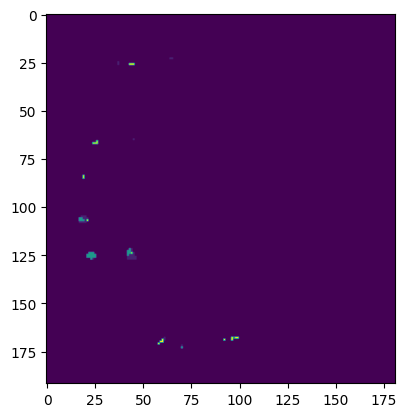

In [31]:
plt.imshow(result_image[:,100,:])

# Script for GPU server

In [ ]:
print('ENTERED THE FILE!')
import os
import numpy as np
from tqdm import tqdm
import torch
import time
from collections import OrderedDict
# import SimpleITK as sitk
import nibabel as nib

#load monai functions
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    ToTensord,
)
from monai.networks.nets import UNETR
from monai.data import Dataset

print('LOADED THE LIBRARYIES')
# device and directory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE:', device)
DATA_PARENT_DIR = '../Task1/brain/'
# DATA_PARENT_DIR = 'brain/'
test_files = [{'image':os.path.join(DATA_PARENT_DIR, file_name, 'mr_normalized.nii.gz'), 'label':file_name} for file_name in os.listdir(DATA_PARENT_DIR)]
GRACE_PATH = 'GRACE.pth'

# defining tranformations
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=0, a_max=1500, b_min=0.0, b_max=1.0, clip=True),
        ToTensord(keys=["image"]),
    ]
    )

# creating the dataset
test_ds = Dataset(
    data=test_files, transform=test_transforms, 
)

# define the model and load weights into it
model = UNETR(
    in_channels=1,
    out_channels=12, #12 for all tissues
    img_size=(64,64,64),
    feature_size=16, 
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

grace_load = torch.load(GRACE_PATH, map_location=torch.device('cpu'), weights_only=False)
grace_load = OrderedDict([(k[7:],v) for k,v in grace_load.items()])

model.load_state_dict(grace_load)
model.eval()

print('MODEL LOADED SUCCESSFULLY')

# inferencing and save the result
case_num = len(test_ds)
begin_time = time.time()
for i in range(case_num):
    with torch.no_grad():
        img_name = test_ds[i]['label']
        img = test_ds[i]['image']
        print(img_name)
        input = img.unsqueeze(0).unsqueeze(1).to(device)
        start_time = time.time()
        output = sliding_window_inference(input, (64, 64, 64), 1, model, overlap=0.0)
        # output = sliding_window_inference(input, (64, 64, 64), 1, model, overlap=0.8)
        print("--- %s seconds ---" % (time.time() - start_time))
    result_image = torch.argmax(output, dim=1).detach().cpu().numpy().squeeze(0)
    # result_image_sitk = sitk.GetImageFromArray(result_image)
    result_image_nib = nib.Nifti1Image(result_image, affine=np.eye(4), dtype=np.int64)
    output_path = os.path.join(DATA_PARENT_DIR, img_name, 'mr_segmented.nii.gz')
    # sitk.WriteImage(result_image_sitk, output_path)
    nib.save(result_image_nib, output_path)
print('TOTAL TIME:')
print("--- %s seconds ---" % (time.time() - begin_time))
print('DONE :)')


## Check the result

In [2]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
import os

../Task1/brain/1BB033


(-0.5, 191.5, 180.5, -0.5)

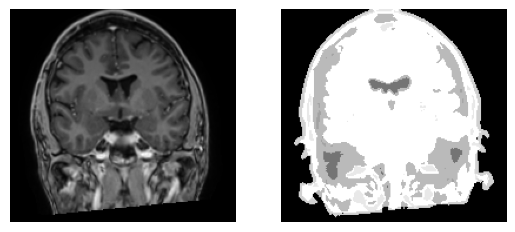

In [34]:
DATA_PARENT_DIR = '../Task1/brain/'
dataset_parent_dir = [os.path.join(DATA_PARENT_DIR, mri_path) for mri_path in os.listdir(DATA_PARENT_DIR)]

# for parent_dir in dataset_parent_dir[:2]:
parent_dir = dataset_parent_dir[0]
mri_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(parent_dir,'mr_normalized.nii.gz')))
segment_img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(parent_dir,'mr_segmented.nii.gz')))

print(parent_dir)
slice_number = 100
temp_mri_img = np.flipud(mri_img)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(temp_mri_img[:,slice_number,:], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(segment_img[:,slice_number,:], cmap='gray')
plt.axis('off')

In [11]:
np.unique(segment_img, return_counts=True)

(array([ 0,  4,  5,  7,  8,  9, 10, 11]),
 array([4645860,      58,   29074,   32027,  707851,  265643,   91060,
        2082379]))

In [10]:
from matplotlib.colors import ListedColormap
LIGHT_BLUE = '#00ffff'
ORANGE = '#ff8040'
PURPLE = '#8000ff'
GREEN = '#16a70b'
LIGHT_PINK = '#ff80c0'
DARK_GREEN = '#008100'
DARK_BLUE = '#0000ff'
NEON_PINK = '#ff00ff'
LIGHT_GREEN = '#00ff00'
GRAY = '#909091' #FIXME: match with image in Drive
TAN = '#ebda96'
LIGHT_RED = '#fa8072'
BLACK = '#000000ff'
BLACK_TRANSPARENT = '#00000000'

#               Light blue          orange              Purple                 Green                   light pink       dark green      dark blue         neon pink            light green      grey                    tan                 light red
RGB_VALUES = [(0, 255, 255, 255), (255, 128, 64, 255), (128, 0, 255, 255), (22, 167, 11, 255), (255, 128, 192, 255), (0, 129, 0, 255), (0, 0, 255, 255), (255, 0, 255, 255), (0, 255, 0, 255), (144, 144, 145, 255), (235, 218, 150, 255), (250, 128, 114, 255)]
RANGES = [[0, 0.5], [0.5, 1.5], [1.5, 2.5], [2.5, 3.5], [3.5, 4.5], [4.5, 5.5], [5.5, 6.5], [6.5, 7.5], [7.5, 8.5], [8.5, 9.5], [9.5, 10.5], [10.5, 11.5]]

def plot_segmented(image_sliced):
    plt.figure()
    plt.imshow(image_sliced, cmap='gray', interpolation='none')
    plt.axis('off')
    rgba_colors = [BLACK_TRANSPARENT, LIGHT_PINK, ORANGE, GRAY, PURPLE, BLACK_TRANSPARENT, DARK_BLUE, NEON_PINK, LIGHT_GREEN, LIGHT_BLUE, BLACK_TRANSPARENT, LIGHT_RED]
    outline_list = [(250, 128, 114, 255), (0, 255, 255, 255), (0, 255, 0, 255), (255, 0, 255, 255), (0, 0, 255, 255), (128, 0, 255, 255), (144, 144, 145, 255), (255, 128, 64, 255), (255, 128, 192, 255)]
    outline_list = outline_list[::-1]
    for num, color in enumerate(rgba_colors):
        if color == BLACK_TRANSPARENT:
            continue
        cmap = ListedColormap([color])
        cmap.set_over((0, 0, 0, 0))
        cmap.set_under((0, 0, 0, 0))
        cmap.set_bad((0, 0, 0, 0))
        plt.imshow(image_sliced, cmap=cmap, interpolation='none', vmin=RANGES[num][0], vmax=RANGES[num][1])
    plt.show()


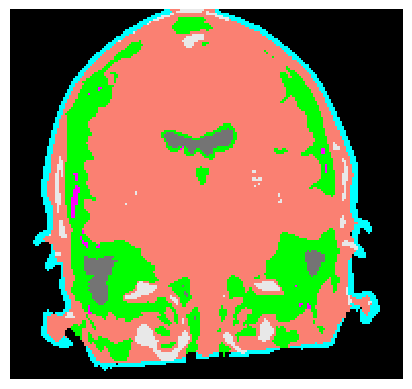

In [ ]:
slice_number = 100
image = segment_img[:,slice_number,:]
plot_segmented(image)
plt.show()

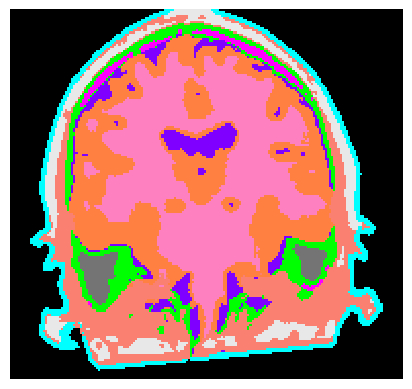

In [11]:
img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join('../Task1','mr_segmented.nii.gz')))
plot_segmented(img[:,100,:])

In [12]:
np.unique(img, return_counts=True)

(array([ 0,  1,  2,  4,  5,  7,  8,  9, 10, 11]),
 array([4575901,  541588,  693410,  167820,   12207,   53800,  237701,
         283846,  484508,  803171]))

In [16]:
import monai
print(monai.__version__)
# from monai.transforms import AddChannelD
from monai.transforms import EnsureChannelFirstd
EnsureChannelFirstd(keys=["image"], channel_dim="no_channel")


1.3.2


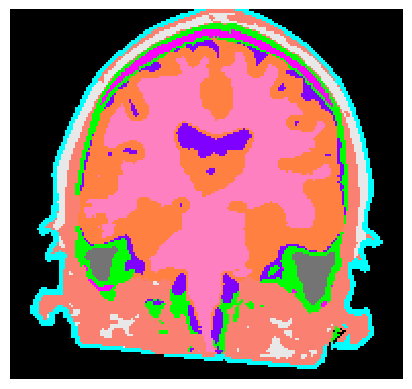

In [29]:
img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join('../Task1','mr_segmented.nii.gz')))
plot_segmented(np.flipud(img[:,100,:]))

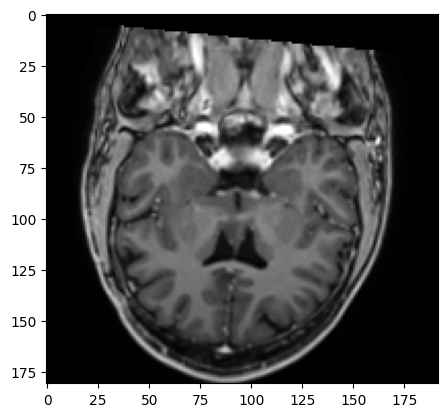

In [49]:
image = mri_img
max_val = 2000
image = np.clip(image, 0, max_val)
image = 255 * image / max_val
image = image.astype(np.uint8)
plt.imshow(image[:,100,:],cmap='gray')

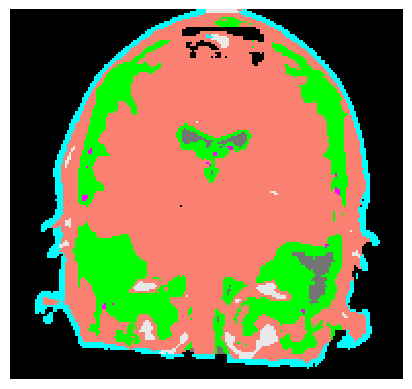

In [50]:
img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join('../Task1','mr_segmented.nii.gz')))
plot_segmented(np.flipud(img[:,100,:]))

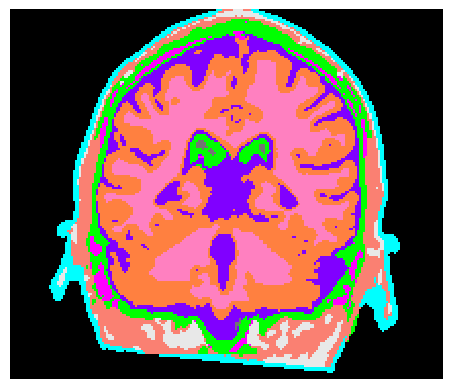

In [51]:
img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join('../Task1','mr_segmented.nii.gz')))
plot_segmented(np.flipud(img[:,100,:]))

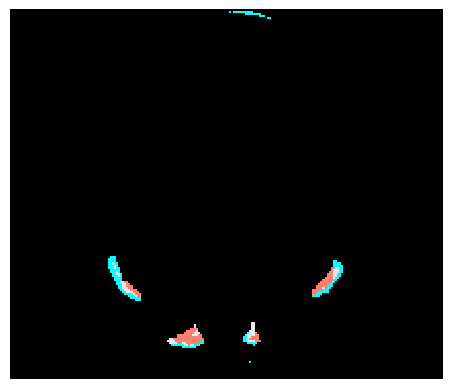

In [52]:
img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join('../Task1','mr_segmented.nii.gz')))
plot_segmented(np.flipud(img[:,100,:]))

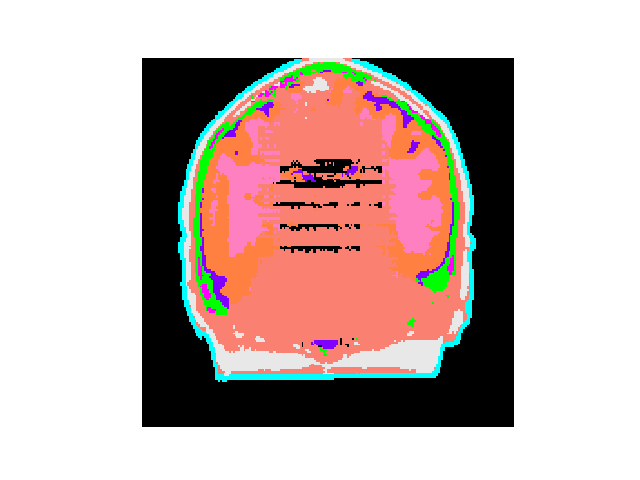

In [55]:
img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join('../Task1','mr_segmented.nii.gz')))
plot_segmented(np.flipud(img[:,100,:]))

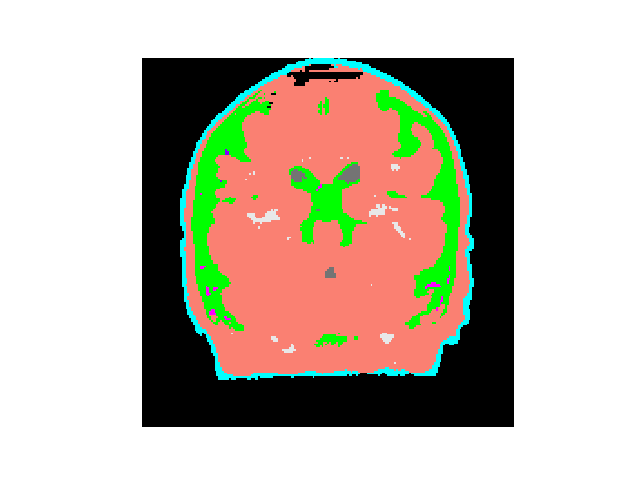

In [56]:
img = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join('../Task1','mr_segmented.nii.gz')))
plot_segmented(np.flipud(img[:,100,:]))

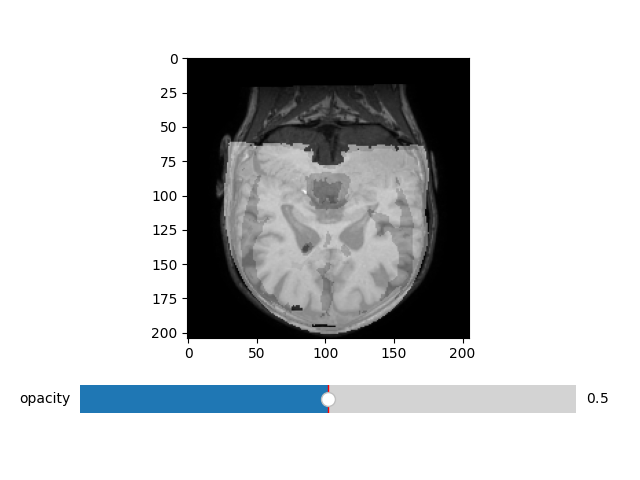

In [57]:
%matplotlib ipympl

import matplotlib.widgets as mpwidgets

OPACITY = 0.5
slice_number = 150
threshold = 30

img_0 = sitk.GetArrayFromImage(sitk.ReadImage('../Task1/brain/1BA294/mr.nii.gz'))
img_1 = sitk.GetArrayFromImage(sitk.ReadImage('../Task1/mr_segmented.nii.gz'))

# PLOT
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]})
img0 = ax0.imshow(img_0[:,slice_number,:], cmap="gray")
# img1 = ax0.imshow(mask[:,slice_number,:], alpha=OPACITY, cmap="gray")
img1 = ax0.imshow(img_1[:,slice_number,:], alpha=OPACITY, cmap="gray")


def update(value): 
    img1.set_alpha(value)    
    fig.canvas.draw_idle()

slider0 = mpwidgets.Slider(ax=ax1, label='opacity', valmin=0, valmax=1, valinit=OPACITY)
slider0.on_changed(update)

plt.show()

In [ ]:
%matplotlib ipympl

import matplotlib.widgets as mpwidgets

OPACITY = 0.5
slice_number = 150
threshold = 30

img_0 = sitk.GetArrayFromImage(sitk.ReadImage('../Task1/brain/1BA294/mr_normalized.nii.gz'))
img_1 = sitk.GetArrayFromImage(sitk.ReadImage('../Task1/mr_segmented.nii.gz'))

# PLOT
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1]})
img0 = ax0.imshow(img_0[:,slice_number,:], cmap="gray")
# img1 = ax0.imshow(mask[:,slice_number,:], alpha=OPACITY, cmap="gray")
img1 = ax0.imshow(img_1[:,slice_number,:], alpha=OPACITY, cmap="gray")


def update(value): 
    img1.set_alpha(value)    
    fig.canvas.draw_idle()

slider0 = mpwidgets.Slider(ax=ax1, label='opacity', valmin=0, valmax=1, valinit=OPACITY)
slider0.on_changed(update)

plt.show()